In [1]:
### run the script from the figures_code directory
import sys
sys.path.insert(0,'../')
import pandas as pd
import numpy as np
import os
import seaborn as sns
import re
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from brokenaxes import brokenaxes
from Bio.Seq import Seq
from functions import params
from functions import parsing
from functions import data_processing as dp
from functions import lib_table_operations as lto
from functions import main_figures as mf
from scipy.stats import zscore

In [2]:
# load parameters
CER_GENOME = params.CER_GENOME
GP = params.GP
libs = params.LIBS_INFO.set_index('Number')
LAB_WT_NORM = params.LAB_WT_NORM
LAB_WT_ZSCORE = params.LAB_WT_ZSCORE
TF_NAMES = params.TF_NAMES
tf_motifs = params.TF_MOTIFS
tf_sumprom = params.TF_SUMPROM
RES_PATH = params.RES_PATH

## (A) Pie chart with info of TFs in our database

([<matplotlib.patches.Wedge at 0x2b0af7027400>,
 [Text(1.080515976669981, 0.2061194414918628, ''),
  Text(0.29581184996001203, 1.0594788102757107, ''),
  Text(-1.0759623476026816, 0.2287029220218362, ''),
  Text(0.27355879508073633, -1.06544149798756, '')])

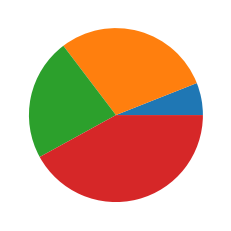

In [3]:
# These results were counted manually. Within our database we found:
# Weak motif binders = 34, Strong motif binders = 63, Zinc cluster TFs - 44. (We didn't profile 9 TFs)
for_pie = [9,44,34,63]
plt.pie(for_pie)

## (A) Demonstration of a putative multi-TF bound region (Edited on illustrator)

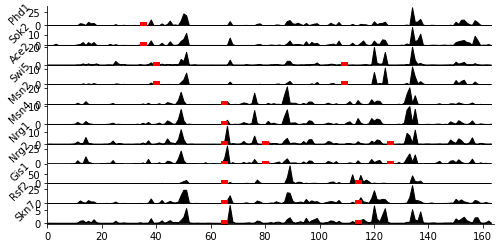

In [4]:
col_map = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
gene = 'Rsm7'
lib_size = 164
prom_length = 1000
edge_length = 0
lib_start = int(libs.loc[libs['Gene']==gene]['Promoter_start_position'].values[0])
g_start,g_end = int(GP.loc[gene.upper()]['TSS_stein_Start']),int(GP.loc[gene.upper()]['TSS_stein_End'])
lib_info = dp.get_lib_info(libs.loc[libs['Gene']==gene].index.values[0])
chromosome = int(GP.loc[gene.upper()]['Chromosome'])
relevant_tfs = libs.loc[libs['Gene']==gene]['Relevant_factors'].values[0].split(' ')
dat_mat = np.empty([len(relevant_tfs),lib_size+(2*edge_length)])
mot_loc = []
for i,tf in enumerate(relevant_tfs):
    mot_loc.append([loc for loc,mut_info in enumerate(lib_info['mut_by_tf']) if re.split('\d',tf)[0] in mut_info])
    if g_start < g_end:
        curr_signal = LAB_WT_ZSCORE[tf][chromosome-1][g_start-prom_length+lib_start-edge_length:
                                                      g_start-prom_length+lib_start+lib_size+edge_length]
    else:
        curr_signal = LAB_WT_ZSCORE[tf][chromosome-1][g_start+prom_length-lib_start+edge_length:
                                                      g_start+prom_length-lib_start-lib_size-edge_length:-1]
    dat_mat[i,:] = curr_signal.T
dat_mat = pd.DataFrame(dat_mat, index=relevant_tfs)
fig, axs = plt.subplots(len(dat_mat.index),1,figsize=(8,4))
for i,tf in enumerate(dat_mat.index):
    plt.subplots_adjust(hspace=0)
    curr_ax = axs.ravel()[i]
    curr_ax.fill_between(range(dat_mat.shape[1]),dat_mat.loc[tf], color='k')
    curr_ax.spines['right'].set_visible(False)
    curr_ax.spines['top'].set_visible(False)
    h = curr_ax.set_ylabel(tf)
    h.set_rotation(45)
    curr_ax.set_xlim((0,lib_size))
    if i < len(dat_mat.index)-1:
        curr_ax.spines['bottom'].set_visible(False)
        curr_ax.get_xaxis().set_ticks([])
        curr_locs = mot_loc[i]
        tf_mut_locs = [lib_info['mut_loc'][loc] for loc in curr_locs]
    curr_ax.scatter(tf_mut_locs,[0]*len(tf_mut_locs), marker='s', color ='r')


## Libraries illustration presented in (C,D and S1B, S1C)

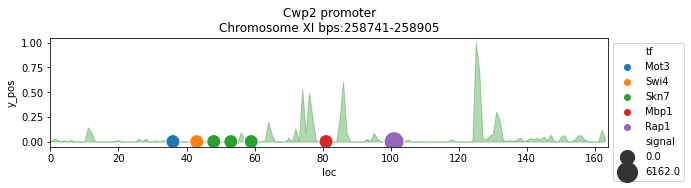

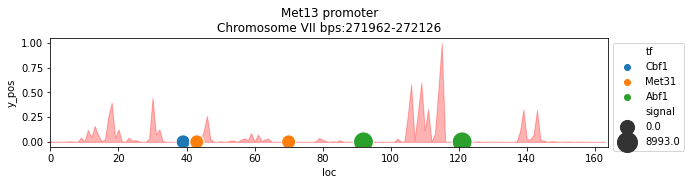

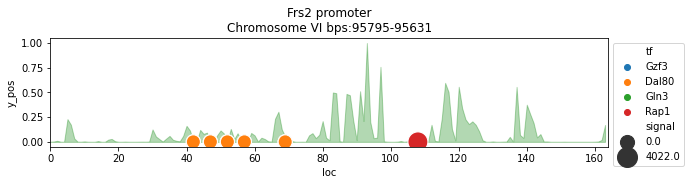

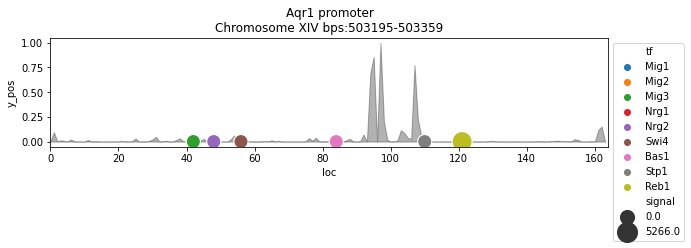

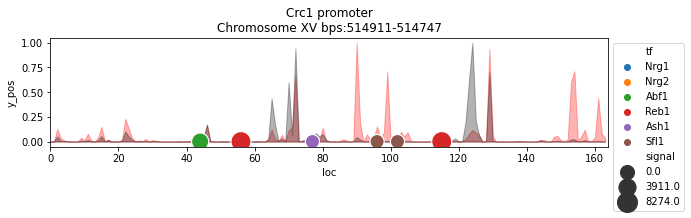

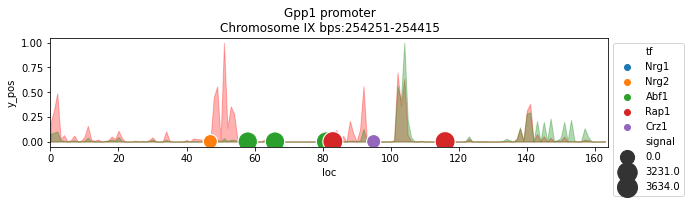

In [5]:
cols = ['r','k','g']
grf_col_dict = {'Reb1':'k','Abf1':'r','Rap1':'g'}
rom_chr = ['I','II','III','IV','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV','XV','XVI']
lib_size = 164
prom_length = 1000
grfs = ['Reb1','Rap1','Abf1']
matching = [i for i,s in enumerate(list(libs['Relevant_factors'].values)) if any(xs in s for xs in grfs)]
rel_libs = libs.iloc[matching,:]
for lib in rel_libs.index:
    lib_info = dp.get_lib_info(lib)

    gene = lib_info['gene']
    lib_start = lib_info['start_position']
    g_start,g_end = int(GP.loc[gene.upper()]['TSS_stein_Start']),int(GP.loc[gene.upper()]['TSS_stein_End'])
    chromosome = int(GP.loc[gene.upper()]['Chromosome'])
    tfs = []
    positions = [] 
    for i,tfs_in_pos in enumerate(lib_info['mut_by_tf']):
        tfs = tfs + tfs_in_pos.split('/')
        positions = positions + [i]*len(tfs_in_pos.split('/'))
    locations = [lib_info['mut_loc'][i] for i in positions]
    grf_pos = [i for i,tf in enumerate(tfs) if tf in grfs]
    tf_types = ['STF']*len(tfs)
    for loc in grf_pos:
        tf_types[loc] = 'GRF'
    opts = np.arange(0,np.max(positions)+1)
    y_pos = np.zeros([1,len(positions)])[0]
    dat_mat = np.empty([len(tfs),lib_size])
    for i,tf in enumerate(tfs):
        if g_start < g_end:
            curr_signal = LAB_WT_NORM[tf][chromosome-1][g_start-prom_length+lib_start:
                                                          g_start-prom_length+lib_start+lib_size]
            lib_start_pos = g_start-prom_length+lib_start
            lib_end_pos =  g_start-prom_length+lib_start+lib_size
        else:
            curr_signal = LAB_WT_NORM[tf][chromosome-1][g_start+prom_length-lib_start:
                                                          g_start+prom_length-lib_start-lib_size:-1]
            lib_start_pos =  g_start+prom_length-lib_start
            lib_end_pos =  g_start+prom_length-lib_start-lib_size
        dat_mat[i,:] = curr_signal.T
    
    sum_signal = np.round(np.sum(dat_mat,axis=1))
    
    
    df = pd.concat([pd.Series(tfs),pd.Series(positions),pd.Series(locations),pd.Series(y_pos),pd.Series(sum_signal),pd.Series(tf_types)],axis=1)
    df.columns = ['tf','pos','loc','y_pos','signal','tf_type']
    df.loc[df['tf_type']=='STF','signal']=0
    grf_pos_data = []
    for grf in np.unique(df.loc[df['tf_type']=='GRF']['tf']):
        grf_pos_data.append(np.min([i for i,tf in enumerate(tfs) if tf==grf]))
    fig,ax = plt.subplots(1,1,figsize=(10,2))
    for grf_pos in grf_pos_data:
        ax.fill_between(range(dat_mat.shape[1]),dat_mat[grf_pos,:]/np.max(dat_mat[grf_pos,:]), color=grf_col_dict[tfs[grf_pos]],alpha=0.3)
    sns.scatterplot(data=df,x='loc',y='y_pos',hue='tf',size='signal',sizes=(200,400),ax=ax)
    cols = ['r','k','g']
    grf_col_dict = {'Reb1':'k','Abf1':'r','Rap1':'g'}
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set_xlim(0,lib_size)
    ax.set_title(gene + ' promoter' +'\n' +'Chromosome ' + rom_chr[chromosome-1] + ' bps:' + str(lib_start_pos) + '-' + str(lib_end_pos))

## (C) Histograms showing sequences on different time points for Reb1 in Aqr1

Text(0.5, 0, 'Log2 normalized reads')

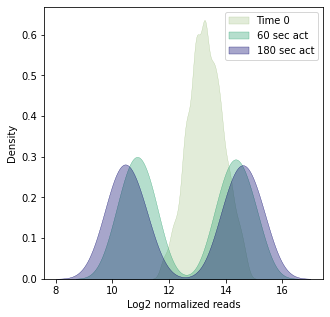

In [3]:
tf = 'Reb1'
lib = 74
exp = 16
lib_info = dp.get_lib_info(lib)
file_name = tf + '_' + str(lib) + '_' + str(exp) + '.csv'  # looking for the relevant results file based on our system ('tf_libnum_exp.csv')
res = (pd.read_csv(os.path.join(RES_PATH, file_name), index_col=0))  # reading current result table into pd dataframe
samp_info = dp.get_samp_info(res)
res_avg_log2 = dp.mean_bio_rep_tps(res,samp_info).apply(np.log2)
fig,ax = plt.subplots(1,1,figsize=(5,5))
colors = ['#adc993','#2ca370','#04026b']
cols = ['1_0','1_60','1_180']
for i in range(len(cols)):
    sns.kdeplot(res_avg_log2[cols[i]],fill=True,ax=ax,bw_adjust=0.5,alpha=.35,color=colors[i],linewidth=.3)
ax.legend(['Time 0','60 sec act','180 sec act'])
ax.set_xlabel('Log2 normalized reads')

## (C) Reb1 occupancy at sequences of the AQR1 library

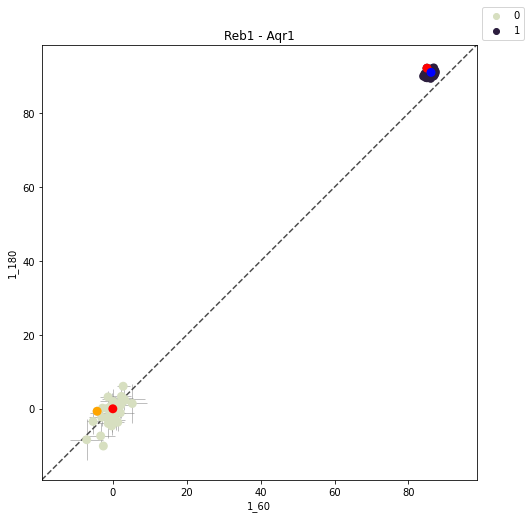

In [7]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
tf = 'Reb1'
tps= ['60','180']
exp_num = '16'
tf_files =  dp.find_tf_files(tf)
lib_num = '74' # Aqr1 library number
tf_pos = lto.get_tf_mot_pos(tf, lib_num)
mf.seq_scatter_by_tf_motifs(tf, lib_num, exp_num, ax=ax, positions=list(tf_pos))

## (C) Reb1 Occupancy at sequences of the AQR1 library containing only one position intact(top) or mutated(bottom)

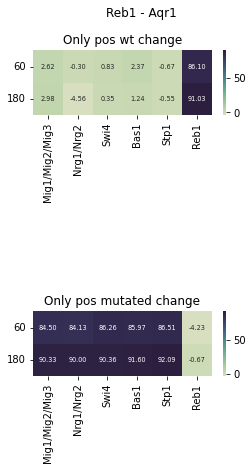

In [12]:
tf = 'Reb1'
tps= ['60','180']
exp_num = '16'
lib_num = '74' # Aqr1 library number
mf.heatmaps_by_tf(tf, lib_num, exp_num, tps)

## (D) Abf1 time course - MET13 library

[<ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>]

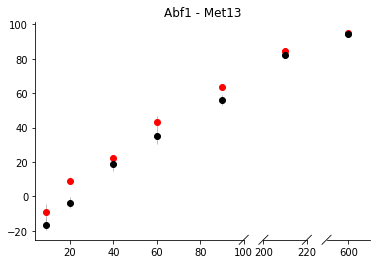

In [4]:
tf = 'Abf1'
exp_num = '26'
lib_num = '51'

lib_info = dp.get_lib_info(lib_num)
wt_var_seq = ''.join(lib_info['wt_at_var_loc'])
res_table = lto.norm_res_data(tf, lib_num, exp_num, norm_to=None, occ=True) * 100
tps = [int(col.split('_')[1]) for col in res_table]
bax = brokenaxes(xlims=((min(tps)-5, tps[-3]+10), (tps[-2]-10,tps[-2]+10), (tps[-1]-10, tps[-1]+10)), hspace=.02)

wt_df = res_table.loc[wt_var_seq].to_frame()
wt_df['TPs'] = tps

file_name = tf + '_' + str(lib_num) + '_' + str(exp_num) + '.csv'  # looking for the relevant results file based on our system ('tf_libnum_exp.csv')
norm_res = (pd.read_csv(os.path.join(RES_PATH, file_name), index_col=0))  # reading current result table into pd dataframe
sample_filt_norm, _ = dp.rm_samples(tf, lib_num, exp_num, norm_res)        
log2_norm = dp.res_log2(sample_filt_norm)
sample_info = dp.get_samp_info(log2_norm)
norm_tp_0 = dp.norm_to_tp_0(log2_norm, sample_info)
norm_uncut = lto.norm_non_cut(lib_num, norm_tp_0, None)
occ = lto.convert_fc_to_occ(norm_uncut) * 100
sample_info = dp.get_samp_info(occ)
curr_exp_df_sem = dp.mean_over_bio_reps(dp.sem_bio_rep_tps(occ, sample_info))
sem_df = curr_exp_df_sem.loc[wt_var_seq].to_frame()
sem_df['TPs'] = tps

bax.errorbar(wt_df['TPs'], wt_df[wt_var_seq], yerr=sem_df[wt_var_seq],ecolor='grey',elinewidth=0.5, color='r', fmt='o')        
bax.set_title(tf + ' - ' + lib_info['gene'])
tf_pos,_ = lto.get_tf_positions(lib_info, tf)
pos_intact_id = lto.get_only_pos_intact(tf_pos, wt_var_seq, res_table)
pos_intact_df = res_table.iloc[pos_intact_id, :].to_frame()
pos_intact_df['TPs'] = tps
bax.errorbar(pos_intact_df['TPs'], pos_intact_df[res_table.index[pos_intact_id]],
     yerr=curr_exp_df_sem.loc[res_table.index[pos_intact_id]],ecolor='grey',elinewidth=0.5, color='k', fmt='o')


## (C) Abf1 Occupancy at sequences of the MET13 library containing only one position intact(top) or mutated(bottom)

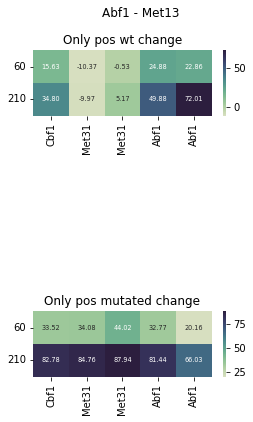

In [14]:
tf = 'Abf1'
exp_num = '26'
lib_num = '51' # MET13 library number
tps= ['60','210']

mf.heatmaps_by_tf(tf, lib_num, exp_num, tps)